# Deep learning from scratch: Final Exam

## Andrew Dai - awd522
### EECS 495 - Watt, Borhani
#### 3/23/2018 - Winter 2018

## General instructions

**1. Complete the problems listed below in this Jupyter notebook - leaving all of your code in Python cells in the notebook itself. Feel free to add any necessary cells.**

**2. The exam is due Friday (3/23) at 11:59 pm. Late submissions will NOT be accepted.**

**3. Make sure you have put your name at the top of this notebook.**

**4. This is the only file you will submit, so make sure all output is present in your notebook prior to submission.**

**5. This exam will be graded out of 60. The last problem (problem 4) is worth 20 points of extra credit. **    

In [1]:
# Activate this cell to import Python packages + custom libraries

# import autograd functionalities
import autograd.numpy as np
from autograd import grad as compute_grad   

# import plotting library and other necessities
import matplotlib.pyplot as plt
from matplotlib import gridspec

# import general libraries
import copy
from datetime import datetime 

# import custom 
import normalizers
from my_convnet_lib import superlearn_setup as setup

#this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

import sys
sys.path.append('../../')

from timeit import default_timer as timer

%load_ext autoreload
%autoreload 2

------

#### <span style="color:#a50e3e;">Problem 1. </span> Short-answer questions (30 points)

Provide a short answer (1-2 sentences maximum) to each each of the following questions. 

------

**1. Why can't we use random search - a zero order method of optimization - to find the optimal weights of a deep learning model?** 

Random search becomes extremely inefficient as either the number of dimensions or the number of weights, or both, increases. It would take literally forever to get anything done if we used random search for deep learning optimization of weights.

------

**2. Why is the Least Squares cost rarely used in linear classification?**

The Least Squares cost is extremely susceptible to outliers in the dataset, which can skew the final linear classification.

------

**3. What is the major difference between One-versus-All (OvA) classification and multiclass softmax classification?** 

A OvA classification model trains C two-class classifiers independently, while a multiclass softmax classification model trains C two-class classifiers simultaneously.

------

**4. Why does gradient descent tend to zig-zag in long narrow valleys? What is one way to fix this issue?**

Since the steplength is proportional to the magnitude of the gradient, as gradient descent approaches stationary points (where the slope is small or close to 0) it takes smaller steps. Coupled with the fact that many deep learning functions have minima in long narrow valleys, it becomes difficult to escape both the magnitude of the steplength and the actual geometry of the function. One fix is to use normalized gradient descent, where the magnitude of the gradient is normalized and the steplength becomes only determined by the alpha parameter.

------

**5. What is the case for normalizing gradient descent in deep learning?**

Normalized gradient descent removes the influence of the magnitude of the gradient when determining the kth steplength and makes it solely determined by the steplength parameter alpha. Most deep learning functions are non-convex, and normalizing gradient descent removes the problem of zig-zagging and easily passes through saddle points and flat regions.

------

**6. A convolutional layer that uses ```ReLU```, i.e., $\max{\left(0, \cdot\right)}$, as nonlinear activation together with ```max-pooling``` as pooling function, is redundant in the sense that we can simplify it by removing the nonlinear activation module in the middle without changing the results. Is that true or false? Explain.**  
<figure><img src="pics/conv_layer.png" width="90%"></figure>

False. Without the nonlinear activation after the convolution operation, the network simplifies down to a basic linear equation regardless of how many layers there are. This drastically changes the results. The nonlinear activation introduces non-linearity and allows the MLP to introduce nonlinearities and accomplish deep learning problems.

------

#### <span style="color:#a50e3e;">Problem 2. </span> CNN vs. MLP (10 points)

In this exercise you will compare the efficacy - in terms of validation error - of two learners: a multilayer perceptron and an associated convnet constructed by layering a single convolutional layer (convolution + pooling) on top of multilayer perceptron.  To do this you will employ a library called `my_convnet_lib` that employs exactly the code you have seen developed this quarter for building optimizers, input normalization, multilayer perceptrons, and convolutional layers.  

A note on jargon: in practice the lower multilayer perceptron portion of a convolutional network is often called its *fully connected layers*, and often in this context multilayer perceptrons are called *fully connected networks*.  

#### Loading in the data

In terms of the experiment - you will use a subset of size $P = 10,000$ the MNIST handwritten digit dataset (of size $70,000$) which you can load in below.  We will call this sample of input/output points `x` and `y` respectively

In [2]:
# load in full MNIST dataset
datapath = 'data/MNIST_subset.csv'
data = np.loadtxt(datapath,delimiter = ',')

# import data and reshape appropriately
x = data[:-1,:]    # input
y = data[-1:,:]    # corresponding output

#### Contrast normalization

Now - before we do any sort of processing, remember we are dealing with images so we should *contrast normalize* them.  To do this we simply *standard normalize* each image.  This is done below employing a backend file `normalizers.py` (which contains many of the input normalizers discussed in class).

In [3]:
# contrast normalize our sample of images - by standard normalizing each one
normalizer,inverse_normalizer = normalizers.standard(x.T)
x = normalizer(x.T).T

We will normalize our input a second time - here using ZCA sphereing - in order to speed up our optimizer's ability to find good minima.  However, as shown with previous libraries, this step is built into the library API below.

#### MLP  run

Below we demonstrate the use of the convolutional network library `my_convnet_lib` to employ a multilayer perceptron / fully connected network to perform classification on our dataset.  Lets go through the API calls shown below line-by-line (or more appropriately, step-by-step).


** Step 1: initialize an instance of the library controller **

In the first line we create an instance of the main controller of the library - called `Setup`.  This takes in the data we wish to perform classification on, `x` and `y`.


** Step 2: initialize a convolutional layer **

In the second line we initialize a convolutional layer for our learner.  The main argument for this constructor is the our desired kernel sizes, defined by the `kernel_sizes` variable.  There are also other optional arguments we can input to define our convolutional layer like those shown, including `conv_stride` (by default set to $1$ as detailed in class) to control the stride of our convolution pass and `pool_stride` (by default set to $2$ as detailed in class) to control the stride of our pooling step.  

For now this step is commented out, since here we want a multilayer perceptron.


** Step 3: initialize a multilayer perceptron / fully connected layer **

This looks very much like the previous version of the library you played with in homework.  Here we define crucial parameters of our multilayer perceptron / fully connected network, including: the activation function used at each layer, the number of hidden layers, the number of hidden units in each layer, and the type of supervised learning we are performing.  Note: here we have improved the UI of the `hidden_layers` variable.  Previously its first and last element were defined to be the dimension of the input / output data respectively.  However now these two parameters are just set on the backend, and so the example given below

```layer_sizes = [10,10,10];```

does indeed define a fully connected network with $3$ hidden layers, and $10$ units per layer.  Also note that the parameter `name` defines whether we use a standard or batch-normalized perceptron scheme in each layer.  By default we have set it too the latter as

```name = multilayer_perceptron_batch_normalized```

You can choose the standard scheme by setting `name` as follows

```name = multilayer_perceptron```

Finally, the `activation` can be set to a variety of functions, like `tanh`, `relu`.

So far we have seen various activation functions, most notably the tanh and relu functions defined below

\begin{array}
\
a(x) = \text{tanh}(w_0 + w_1x) \\
a(x) = \text{max}(0,w_0 + w_1x) \\
\end{array}

Here you will implement the so-called [*maxout* activation](https://arxiv.org/pdf/1302.4389.pdf).  This function, defined as

\begin{array}
\
a(x) = \text{max}(v_0 + v_1x, \,w_0 + w_1x) \\
\end{array}

takes maximum of two linear combinations of the input, instead of one linear combination and zero like the relu function.  While this change is algebraically rather minor, multilayer perceptron architectures employing the *maxout* activation tends to have certain advantages over those employing tanh and relu activations, including

- fewer issues with problematic initialization  e.g., values close too (or equal to) zero for the *relu* activation are bad because the relu is minimized at zero

- fewer issues with gradients vanishing or exploding, as can occur when using the tanh activation

- faster convergence with far fewer gradient descent steps

These advantages come with a simple price: the maxout activation has twice as many internal parameters as either the relu or tanh, hence architectures built with them have roughly twice as many parameters to tune.


** Step 4: split the data into training and validation sets **

Here we split our input data into a training and validation portions.  Remember: we want to measure how well our `model` fits the data based on its *validation* error, not its training error.  Here the variable `train_portion` defines whcih portion of the input data is reserved for training, with the remaining portion set aside for validation purposes.


** Step 5: choose an input normalization scheme **

Here we choose an input normalizer - here set to `ZCA_sphere` for ZCA sphereing.


** Step 6: choose cost function **

Pretty straightforward.  For multiclass classification you can choose from the multiclass softmax function `multiclass_softmax` or multiclass perceptron `multiclass_perceptron`.


** Step 7: optimizer **

Here we run gradient based optimization using mini-batches.  Here the input variables `max_its`, `alpha_choice`, and `batch_size` control the number of iterations (epochs = full sweeps through the data), steplength parameter, and size of mini-batch respectively.  Note that after each complete sweep through the data - called an *epoch* - an update including the time to completion, and current training / validation cost values are printed.


** Step 8: plot training and validation histories **

Here we plot the training and validation cost function histories in the left panel, and the corresponding accuracies at each step in the right panel.

Running the cell below will produce the training / validation histories shown afterwards.  Notice how the validation cost bottoms out fairly early, increasing for the remaining iterations.  However the validation accuracy reaches its peak somewhere in the middle of the run. 

C:\Users\andre\Anaconda3\lib\site-packages\matplotlib\figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


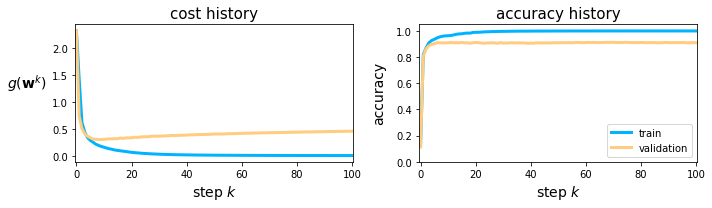

In [4]:
# Step 1: import the setup module of our convnet library
mylib1 = setup.Setup(x,y)

# Step 2: define convolution layer

# Step 3: define fully connected / multilayer perceptron layers
layer_sizes = [10,10,10];
name = 'multilayer_perceptron_batch_normalized'
super_type = 'classification'
activation = 'maxout'
mylib1.choose_features(name = name,layer_sizes = layer_sizes,super_type = super_type,activation = activation)

# Step 4: split data into training and testing sets
mylib1.make_train_val_split(train_portion = 0.8)

# Step 5: choose input normalization scheme
mylib1.choose_normalizer(name = 'ZCA_sphere')

# Step 6: choose cost function
mylib1.choose_cost(name = 'multiclass_softmax')

# Step 7: run optimization algo
mylib1.fit(max_its = 100, alpha_choice = 10**(0),batch_size = 500)

# Step 8: Plot training / validation histories
mylib1.show_histories(start = 0)

To pluck out the best validation accuracy - the measurement we really care about here - run the cell below.

In [5]:
# pluck out the highest validation accuracy from the run above
ind1 = np.argmax(mylib1.val_accuracy_histories[0])
best_result1 = mylib1.val_accuracy_histories[0][ind1]
print ('from this run our best validation accuracy was ' + str(np.round(best_result1*100,2)) + '% at step ' + str(ind1))

from this run our best validation accuracy was 91.35% at step 70


#### CNN run

The same code used above is copied below, with the convolutional layer defined and added, plus a slight change to Step 4 (to make sure we use the same training / validation data in the next experiment).  The parameters of Step 3 - where you defined your fully connected layers - is the same here. The number of convolutional kernels will be set by you. 

Note: even though we have optimized the convolutional layer (and fully connected layers) for processing on multiple cpu cores, depending on your machine each step (or *epoch*) could take some time to complete.  For this reason, you have the option to increase the `conv_stride` from $1$ to $2$ or even larger - this may decrease the efficacy of the convolutional layer but will at the same time significantly decrease the amount of computation required (indeed the computation decreases *quadratically* with this parameter), yet you should still be able to make significant improvement over the previous network.

Make a run with a maximum of around $20$ steps to see how much you can improve the validation accuracy with this simple convolutional network in comparison to the multilayer perceptron used above.

In [6]:
# number of 3x3 convolutional kernels to learn (set by you)
num_kernels = 10

# convolution stride (set by you)
conv_stride = 1

C:\Users\andre\Anaconda3\lib\site-packages\matplotlib\figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


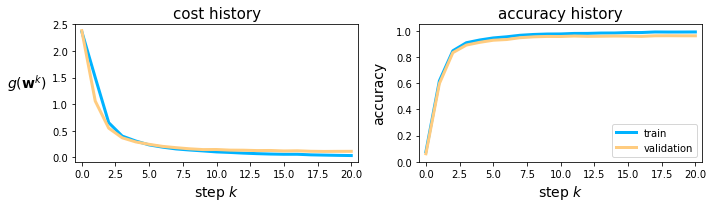

In [7]:
# Step 1: import the setup module of our convnet library
mylib2 = setup.Setup(x,y)

# Step 2: define convolution layer
kernel_sizes = [num_kernels,3,3]
pool_stride = 2
mylib2.choose_convolutions(kernel_sizes = kernel_sizes,conv_stride = conv_stride, pool_stride = pool_stride)

# Step 3: define fully connected / multilayer perceptron layers
layer_sizes = [10,10,10];
name = 'multilayer_perceptron_batch_normalized'
super_type = 'classification'
activation = 'maxout'
mylib2.choose_features(name = name,layer_sizes = layer_sizes,super_type = super_type,activation = activation,scale = 0.1)

# Step 4: split data into training and testing sets
mylib2.x_train = mylib1.x_train
mylib2.y_train = mylib1.y_train
mylib2.x_val = mylib1.x_val
mylib2.y_val = mylib1.y_val

# Step 5: choose input normalization scheme
mylib2.choose_normalizer(name = 'ZCA_sphere')

# Step 6: choose cost function
mylib2.choose_cost(name = 'multiclass_softmax')

# Step 7: run optimization algo
mylib2.fit(max_its = 20, alpha_choice = 10**(0), batch_size = 500)

# Step 8: Plot training / validation histories
mylib2.show_histories(start = 0)

In [8]:
# pluck out the highest validation accuracy from the run above
ind2 = np.argmax(mylib2.val_accuracy_histories[0])
best_result2 = mylib2.val_accuracy_histories[0][ind2]
print ('from this run our best validation accuracy was ' + str(np.round(best_result2*100,2)) + '% at step ' + str(ind2))

from this run our best validation accuracy was 96.35% at step 18


**Question: How much - in terms of percentage of validation accuracy -  was the overall classification improved after adding a single convolutional layer?** 

### Validation accuracy improved by 5%. (96.35% - 91.35%)

-----

#### <span style="color:#a50e3e;">Problem 3. </span> Humpty Dumpty! (20 points)

Randy is collecting data for two different machine learning tasks. Task A is to predict whether a student passes or fails a certain test based on their past academic record. Task B is to predict whether a debtor defaults on their debt based on their past financial record. The dataset for each task has $P=100$ datapoints. 

When saving the data, Randy messed up and forgot to put the input features and labels together, and now he doesn't remember which label vector $\mathbf{y}$ goes with which input matrix $\mathbf{X}$. Can you help Randy pair them correctly? 

Activate the cell below to load Randy's data.

In [9]:
# load in X_A: input data for task A
X_A = np.loadtxt('data/X_A.txt', delimiter=',')

# load in X_B: input data for task B
X_B = np.loadtxt('data/X_B.txt', delimiter=',')

# load in y1: one of the label vectors, we don't know what task it belongs to!  
y1 = np.reshape(np.loadtxt('data/y1.txt', delimiter=','), (-1,1)).T

# load in y2: the other label vector! we don't know what task it belongs to! 
y2 = np.reshape(np.loadtxt('data/y2.txt', delimiter=','), (-1,1)).T

To answer this question, first come up with a strategy and explain the rationale behind it, i.e., why you think it should work. Then use your strategy to connect the $\mathbf{X}$'s to the $\mathbf{y}$'s.  

Hint: you can use our deep learning library introduced in Problem 2.   

#### Strategy:
Using a MLP, we can plot the cost history and misclassification history as a function of the kth iteration. If the labels are paired correctly with the correct dataset, the model will be able to properly tune a set of weights since the output features will be related with the labels. Subsequently, the cost history and the misclassification history should both decrease. If the dataset / label pair is incorrect, there should be no obvious trend as the kth iteration increases, since the labels will have nothing to do with the calculated features from the input dataset.

In [49]:
# Quickly check the data
print('shape of X_A: ' + str(np.shape(X_A)))
print('shape of X_B: ' + str(np.shape(X_B)))
print('shape of y1: ' + str(np.shape(y1)))
print('shape of y2: ' + str(np.shape(y2)))
print('y1 label values: ' + str(np.unique(y1)) + ' and is type ' + str(y1.dtype))
print('y2 label values: ' + str(np.unique(y2)) + ' and is type ' + str(y2.dtype))

shape of X_A: (5, 100)
shape of X_B: (5, 100)
shape of y1: (1, 100)
shape of y2: (1, 100)
y1 label values: [-1.  1.] and is type float64
y2 label values: [-1.  1.] and is type float64


### First, let's try X_A with y1:

C:\Users\andre\Anaconda3\lib\site-packages\matplotlib\figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


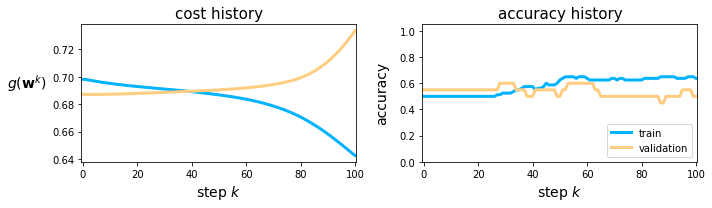

In [58]:
## X_A data paired wity y1 labels:
# Step 1: import the setup module of our convnet library
mylib3 = setup.Setup(X_A,y1)

# Step 2: define convolution layer

# Step 3: define fully connected / multilayer perceptron layers
layer_sizes = [10,10,10];
name = 'multilayer_perceptron'
super_type = 'classification'
activation = 'relu'
mylib3.choose_features(name = name,layer_sizes = layer_sizes,super_type = super_type,activation = activation)

# Step 4: split data into training and testing sets
mylib3.make_train_val_split(train_portion = 0.8)

# Step 5: choose input normalization scheme
mylib3.choose_normalizer(name = 'standard')

# Step 6: choose cost function
mylib3.choose_cost(name = 'softmax')

# Step 7: run optimization algo
mylib3.fit(max_its = 100, alpha_choice = 10**(-1),batches=500)

# Step 8: Plot training / validation histories
mylib3.show_histories(start = 0)

### X_A and y1 does not look good -- let's try X_A and y2 now:

C:\Users\andre\Anaconda3\lib\site-packages\matplotlib\figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


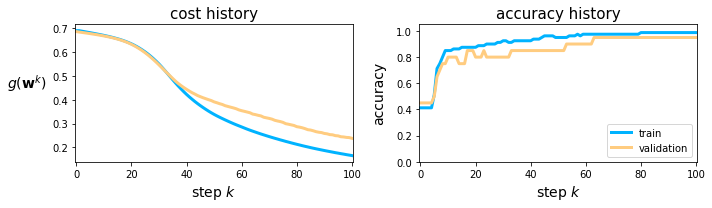

In [59]:
## X_A data paired wity y2 labels:
# Step 1: import the setup module of our convnet library
mylib3 = setup.Setup(X_A,y2)

# Step 2: define convolution layer

# Step 3: define fully connected / multilayer perceptron layers
layer_sizes = [10,10,10];
name = 'multilayer_perceptron'
super_type = 'classification'
activation = 'relu'
mylib3.choose_features(name = name,layer_sizes = layer_sizes,super_type = super_type,activation = activation)

# Step 4: split data into training and testing sets
mylib3.make_train_val_split(train_portion = 0.8)

# Step 5: choose input normalization scheme
mylib3.choose_normalizer(name = 'standard')

# Step 6: choose cost function
mylib3.choose_cost(name = 'softmax')

# Step 7: run optimization algo
mylib3.fit(max_its = 100, alpha_choice = 10**(-1),batches=500)

# Step 8: Plot training / validation histories
mylib3.show_histories(start = 0)

### Looks much better! X_A pairs nicely with y2. This means X_B and y1 are related as well, let's try below:

C:\Users\andre\Anaconda3\lib\site-packages\matplotlib\figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


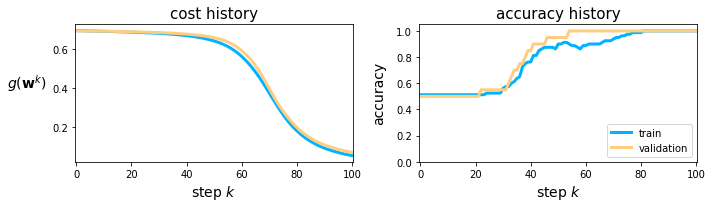

In [60]:
## X_B data paired wity y1 labels:
# Step 1: import the setup module of our convnet library
mylib3 = setup.Setup(X_B,y1)

# Step 2: define convolution layer

# Step 3: define fully connected / multilayer perceptron layers
layer_sizes = [10,10,10];
name = 'multilayer_perceptron'
super_type = 'classification'
activation = 'relu'
mylib3.choose_features(name = name,layer_sizes = layer_sizes,super_type = super_type,activation = activation)

# Step 4: split data into training and testing sets
mylib3.make_train_val_split(train_portion = 0.8)

# Step 5: choose input normalization scheme
mylib3.choose_normalizer(name = 'standard')

# Step 6: choose cost function
mylib3.choose_cost(name = 'softmax')

# Step 7: run optimization algo
mylib3.fit(max_its = 100, alpha_choice = 10**(-1),batches=500)

# Step 8: Plot training / validation histories
mylib3.show_histories(start = 0)

### X_B and y1 also looks good! Better than X_A with y1.

### Just for sanity check, let's try X_B and y2 to make sure it looks bad:

C:\Users\andre\Anaconda3\lib\site-packages\matplotlib\figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


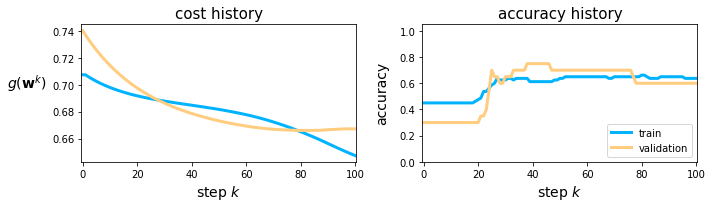

In [61]:
# Step 1: import the setup module of our convnet library
mylib3 = setup.Setup(X_B,y2)

# Step 2: define convolution layer

# Step 3: define fully connected / multilayer perceptron layers
layer_sizes = [10,10,10];
name = 'multilayer_perceptron'
super_type = 'classification'
activation = 'relu'
mylib3.choose_features(name = name,layer_sizes = layer_sizes,super_type = super_type,activation = activation)

# Step 4: split data into training and testing sets
mylib3.make_train_val_split(train_portion = 0.8)

# Step 5: choose input normalization scheme
mylib3.choose_normalizer(name = 'standard')

# Step 6: choose cost function
mylib3.choose_cost(name = 'softmax')

# Step 7: run optimization algo
mylib3.fit(max_its = 100, alpha_choice = 10**(-1),batches=500)

# Step 8: Plot training / validation histories
mylib3.show_histories(start = 0)

### From four graphs above, it's abundantly clear the MLP model we used can pick up weights and tune a relationship between X_A data with y2 labels, and X_B data with y1 labels. Final answer is below:

$\mathbf{y}_1$ corresponds to task B

$\mathbf{y}_2$ corresponds to task A

----------

#### <span style="color:#a50e3e;">Problem 4. </span> The minimum is just a single step away! (20 points of extra credit)

Forming the Least Squares regression cost on a dataset with scalar input (i.e., $N=1$) has resulted in the following quadratic cost function

$$g(\mathbf{w}) = \frac{1}{2} \mathbf{w}^T\mathbf{A}\mathbf{w}+\mathbf{b}^T\mathbf{w}+c$$

where $\mathbf{w} = \begin{bmatrix} w_0 \\ w_1 \end{bmatrix}$ contains the bias parameter $w_0$ and the slope parameter $w_1$, $\mathbf{A} = \begin{bmatrix} 1\,\,1 \\ 1 \,\, 4\end{bmatrix}$, $\mathbf{b} = \begin{bmatrix} -1 \\ 0 \end{bmatrix}$, and $c=3$.

 We want to employ gradient descent to (precisely) reach the minimum of $g$, starting at the initial point $\mathbf{w}^{0} = \begin{bmatrix} 1 \\ 1 \end{bmatrix}$. Here's the catch: we are only allowed to take <strong>one</strong> gradient descent step!

---------

**I. Can this be done using vanilla gradient descent (Eq. 2 in [Section 6.4](https://jermwatt.github.io/mlrefined/blog_posts/6_First_order_methods/6_4_Gradient_descent.html))? If yes, provide the value of the steplength parameter $\alpha$ that makes it happen. If no, explain why not.**

Plugging in $\mathbf{w} = \begin{bmatrix} w_0 \\ w_1 \end{bmatrix}$ with our given parameters given parameters $\mathbf{A} = \begin{bmatrix} 1\,\,1 \\ 1 \,\, 4\end{bmatrix}$, $\mathbf{b} = \begin{bmatrix} -1 \\ 0 \end{bmatrix}$ and $c=3$ into our cost function $g(\mathbf{w})$ yields the following:

$$g(\begin{bmatrix} w_0 \\ w_1 \end{bmatrix}) = \frac{1}{2} \begin{bmatrix} w_0\,\,w_1 \end{bmatrix} \cdot \begin{bmatrix} 1\,\,1 \\ 1 \,\, 4\end{bmatrix} \cdot \begin{bmatrix} w_0 \\ w_1 \end{bmatrix} + \begin{bmatrix} -1\,\,0 \end{bmatrix} \cdot \begin{bmatrix} w_0 \\ w_1 \end{bmatrix} + 3$$

After simplifying, this yields the final cost equation as:

$$g(w_0, w_1) = \frac{1}{2}w_0^2 + w_0w_1 + 2w_1^2 - w_0 + 3$$

To find the gradient of this cost function, we will take the partial derivative with respect to both $w_0$ and $w_1$ and then restack these answers to create our gradient $\mathbf{\nabla}g(\mathbf{w})$

$$\frac{\partial g(w_0, w_1)}{\partial w_0} = w_0 + w_1 - 1$$

$$\frac{\partial g(w_0, w_1)}{\partial w_1} = w_0 + 4w_1$$

Which we can construct in order to calculate the gradient $\mathbf{\nabla}g(\mathbf{w})$ into:

$$\mathbf{\nabla}g(\mathbf{w}) = \begin{bmatrix} w_0 + w_1 - 1 \\ w_0 + 4w_1 \end{bmatrix}$$

The minimum of our cost function can be found from taking its derivative while keeping $\mathbf{w}$ in vector form, which when we set equal to a zero matrix $\begin{bmatrix} 0 \\ 0 \end{bmatrix}$ we can solve for the minimum weight vector $\mathbf{w}^* = \begin{bmatrix} w_0^* \\ w_1^* \end{bmatrix}$.

$$g'(\mathbf{w}) = \mathbf{A}\cdot\mathbf{w^*}+\mathbf{b} = \begin{bmatrix} 1\,\,1 \\ 1\,\,4 \end{bmatrix} \cdot \begin{bmatrix} w_0^* \\ w_1^* \end{bmatrix} + \begin{bmatrix} -1 \\ 0 \end{bmatrix} = \begin{bmatrix} 0 \\ 0 \end{bmatrix}$$

Solving the above equation yields $\mathbf{w^*} = \begin{bmatrix} \frac{4}{3} \\ \frac{-1}{3} \end{bmatrix}$ which we can now plug into the vanilla gradient descent equation $\mathbf{w}^k = \mathbf{w}^{k-1} - \mathbf{\alpha}\mathbf{\nabla}g(\mathbf{w}^{k-1})$, with $\mathbf{w^*}$ as the desired weight $\mathbf{w}^k$ and $\mathbf{\nabla}g(\begin{bmatrix} w_0 \\ w_1 \end{bmatrix})$ to find the steplength paramater $\alpha$.

$$\begin{bmatrix} \frac{4}{3} \\ \frac{-1}{3} \end{bmatrix} = \begin{bmatrix} 1 \\ 1 \end{bmatrix} - \mathbf{\alpha}\begin{bmatrix} 1 + 1 - 1 \\ 1 + (4\cdot1) \end{bmatrix} = \begin{bmatrix} 1 \\ 1 \end{bmatrix} - \mathbf{\alpha}\begin{bmatrix} 1 \\ 5 \end{bmatrix}$$

Simplifying this equation further yields: $\begin{bmatrix} \frac{1}{3} \\ \frac{-4}{3} \end{bmatrix} = -\mathbf{\alpha}\begin{bmatrix} 1 \\ 5 \end{bmatrix}$ for which there is no soltuion, as there is no value of $\alpha$ which will produce a weight vector $\mathbf{w}$ with $w_0$ and $w_1$ having opposite signs from our starting point $\mathbf{w}^0 = \begin{bmatrix} 1 \\ 1 \end{bmatrix}$

### Solution to Problem 4 (I):
There is no steplength parameter $\alpha$ which can reach the minimum of $g(\mathbf{w})$ in just one step when given those specific parameters. There is no value of $\alpha$ which will produce the desired weight vector $\mathbf{w}$ with $w_0$ and $w_1$ having different signs.

---------

**II. Can this be done using normalized gradient descent (Eq. 2 in [Section 13.3](https://jermwatt.github.io/mlrefined/blog_posts/13_Multilayer_perceptrons/13_3_Normalized_gradient_descent.html))? If yes, provide the value of the steplength parameter $\alpha$ that makes it happen. If no, explain why not.**

Normalized gradient descent simply normalizes the value of the gradient $\mathbf{\nabla}g(\mathbf{w})$, which will still not produce a proper steplength parameter $\mathbf{\alpha}$ which can reach the minimum of our cost function $g(\mathbf{w})$. This is demonstrated in the cells below.

The normalized gradient descent equation is:

$$\mathbf{w}^k = \mathbf{w}^{k-1} - \mathbf{\alpha}\frac{\mathbf{\nabla}g(\mathbf{w}^{k-1})}{\lVert \mathbf{\nabla}g(\mathbf{w}^{k-1}) \rVert}_2$$

The equation to solve for the steplength $\alpha$ to reach the minimum of our cost function is now updated to:

$$\begin{bmatrix} \frac{1}{3} \\ \frac{-4}{3} \end{bmatrix} = -\mathbf{\alpha}\begin{bmatrix} \frac{1}{\sqrt{26}} \\ \frac{1}{\sqrt{26}} \end{bmatrix}$$

As before in Problem 4 (I), there is still no solution to this equation.

### Solution to Problem 4 (II):
Even when using normalized gradient descent, there is still no steplength parameter $\alpha$ which can reach the minimum of $g(\mathbf{w})$ in just one step when given those specific parameters. There is no value of $\alpha$ which will produce the desired weight vector $\mathbf{w}$ with $w_0$ and $w_1$ having different signs.

---------

**III. Can this be done using gradient descent with momentum (Eq. 1 in [Section 13.4](https://jermwatt.github.io/mlrefined/blog_posts/13_Multilayer_perceptrons/13_4_Momentum_methods.html))? If yes, provide the values of the steplength parameter $\alpha$ and momentum parameter $\beta$ that make it happen. If no, explain why not.**

The equation for gradient descent with momentum is as follows:

$$\mathbf{w}^{k+1} = \mathbf{w}^k - \mathbf{\alpha}\mathbf{\nabla}g(\mathbf{w}^k) + \mathbf{\beta}(\mathbf{w}^k - \mathbf{w}^{k-1})$$

Since we can only take one step, we can assume that $\mathbf{w}^{k-1} = \begin{bmatrix} 0 \\ 0 \end{bmatrix}$

Thus, our final equation solving for the values of the parameters $\mathbf{\alpha}$ and $\mathbf{\beta}$ which will get to the minimum of our cost function $g(\mathbf{w})$ is as follows:

$$\begin{bmatrix} \frac{1}{3} \\ \frac{-4}{3} \end{bmatrix} = -\mathbf{\alpha}\begin{bmatrix} 1 \\ 5 \end{bmatrix} + \mathbf{\beta}\begin{bmatrix} 1 \\ 1 \end{bmatrix}$$

Which can be reorganized as:

$$\begin{bmatrix} \frac{1}{3} \\ \frac{-4}{3} \end{bmatrix} = \begin{bmatrix} -1\,\,1 \\ -5\,\,1 \end{bmatrix} \cdot \begin{bmatrix} \mathbf{\alpha} \\ \mathbf{\beta} \end{bmatrix} $$

This equation, unlike in Problem 4 (I) and Problem 4 (II), has a solution and the corresponding values of $\mathbf{\alpha}$ and $\mathbf{\beta}$ are listed below:

$$\mathbf{\alpha} = 0.4167, \mathbf{\beta} = 0.7500$$

### Solution to Problem 4 (III):
When using gradient descent with momentum, setting the steplength parameter $\mathbf{\alpha} = 0.4167$ and the momentum parameter $\mathbf{\beta} = 0.7500$ will allow for us to reach the minimum of our cost function $g(\mathbf{w})$ when starting at $\mathbf{w}_0 = \begin{bmatrix} 1 \\ 1 \end{bmatrix}$ via the optimal weight vector $\mathbf{w}^* = \begin{bmatrix} \frac {4}{3} \\ \frac{-1}{3} \end{bmatrix}$ with just one step.

---------

**IV. Repeat part III, this time for a general $N$ dimensional input. That is, $\mathbf{A}$ is now a symmetric $(N+1)\times (N+1)$ matrix, $\mathbf{b}$ an $(N+1)\times 1$ vector, and $c$ still a scalar. Is it possible to reach the global minimum of $g$ in one step using the momentum trick regardless of how $\mathbf{w}^{0}$ is initialized? If yes, provide the values of steplength parameter $\alpha$ and momentum parameter $\beta$ that make it happen (in terms of $\mathbf{A}$, $\mathbf{b}$, $c$, and $\mathbf{w}^{0}$). If no, explain why not.**

In general, the weight vector $\mathbf{w}^*$ which will allow the gradient descent with momentum to reach the minimum of the cost function $g(\mathbf{w})$ is of the form:

$$\mathbf{w}^* = \mathbf{A}^{-1} \cdot -\mathbf{b}$$

With this result, when modifying the gradient descent with momentum equation $\mathbf{w}^{k+1} = \mathbf{w}^k - \mathbf{\alpha}\mathbf{\nabla}g(\mathbf{w}^k) + \mathbf{\beta}(\mathbf{w}^k - \mathbf{w}^{k-1})$ we can produce the following equation, the solution of which produces the values of $\mathbf{\alpha}$ and $\mathbf{\beta}$ in order to reach the global minimum of our cost function $g(\mathbf{w})$ in one step.

$$[\mathbf{A}^{-1} \cdot -\mathbf{b}] - \mathbf{w}^0 = \begin{bmatrix} - \mathbf{\nabla}g(\mathbf{w}^0) \,\, \mathbf{w}^0 \end{bmatrix} \cdot \begin{bmatrix} \mathbf{\alpha} \\ \mathbf{\beta} \end{bmatrix}$$

Which we can simplify down to:

$$\begin{bmatrix} \mathbf{\alpha} \\ \mathbf{\beta} \end{bmatrix} = \begin{bmatrix} - \mathbf{\nabla}g(\mathbf{w}^0) \,\, \mathbf{w}^0 \end{bmatrix}^{-1}_{left} \cdot [[\mathbf{A}^{-1} \cdot -\mathbf{b}] - \mathbf{w}^0]$$

#### An important consideration above is that the matrix $\begin{bmatrix} - \mathbf{\nabla}g(\mathbf{w}^0) \,\, \mathbf{w}^0 \end{bmatrix}$ *MUST* have a left inverse (denoted as $\begin{bmatrix} - \mathbf{\nabla}g(\mathbf{w}^0) \,\, \mathbf{w}^0 \end{bmatrix}^{-1}_{left}$) or else there will be no way to calculate the parameters. That is the only condition on a general $N$ dimensional input.

### Solution to Problem 4 (IV):
The values of the steplength parameter $\mathbf{\alpha}$ and momentum parameter $\mathbf{\beta}$ in order to always reach the global minimum of our cost function $g(\mathbf{w})$ in just one step are:

$$\begin{bmatrix} \mathbf{\alpha} \\ \mathbf{\beta} \end{bmatrix} = \begin{bmatrix} - \mathbf{\nabla}g(\mathbf{w}^0) \,\, \mathbf{w}^0 \end{bmatrix}^{-1}_{left} \cdot [[\mathbf{A}^{-1} \cdot -\mathbf{b}] - \mathbf{w}^0]$$

#### As mentioned above, this solution only holds if the matrix $\begin{bmatrix} - \mathbf{\nabla}g(\mathbf{w}^0) \,\, \mathbf{w}^0 \end{bmatrix}$ has a left inverse (denoted as $\begin{bmatrix} - \mathbf{\nabla}g(\mathbf{w}^0) \,\, \mathbf{w}^0 \end{bmatrix}^{-1}_{left}$) or else there will be no way to calculate the parameters. That is the only condition on a general $N$ dimensional input.

#### This is not the case for the inverse of $A$, since Problem 4 (IV) mentions that $A$ is square. This problem arises since the dimensions of $ -\mathbf{\nabla}g(\mathbf{w}^0)$ and $ \mathbf{w}^0$ within the matrix are both $(N+1) \times 1$, so that the final dimension of the combined matrix is $(N+1) \times 2$.

#### If we assume that the matrix $\begin{bmatrix} - \mathbf{\nabla}g(\mathbf{w}^0) \,\, \mathbf{w}^0 \end{bmatrix}$ has a left inverse, then the dimensions of the final solution work out to produce the correct dimensions on the final $\begin{bmatrix} \mathbf{\alpha} \\ \mathbf{\beta} \end{bmatrix}$ matrix. This is demonstrated below.

$$\begin{bmatrix} \mathbf{\alpha} \\ \mathbf{\beta} \end{bmatrix} = \begin{bmatrix} - \mathbf{\nabla}g(\mathbf{w}^0) \,\, \mathbf{w}^0 \end{bmatrix}^{-1}_{left} \cdot [[\mathbf{A}^{-1} \cdot -\mathbf{b}] - \mathbf{w}^0]$$

Dimensions on $[[\mathbf{A}^{-1} \cdot -\mathbf{b}] - \mathbf{w}^0]: [((N+1)\times(N+1)) \cdot ((N+1)\times1)] - (N+1)\times1) = (N+1)\times1 - (N+1)\times1) = \mathbf{(N+1)\times1}$

Dimensions on $\begin{bmatrix} - \mathbf{\nabla}g(\mathbf{w}^0) \,\, \mathbf{w}^0 \end{bmatrix}^{-1}_{left}$: $[((N+1)\times1),((N+1)\times1)]^{-1} = ((N+1)\times2)^{-1} = \mathbf{2\times(N+1)}$

Final solution dimension check on $\begin{bmatrix} \mathbf{\alpha} \\ \mathbf{\beta} \end{bmatrix}$: $(2\times(N+1)) \cdot ((N+1)\times1) = \mathbf{2\times1}$

Which yields the correct dimensions for the matrix $\begin{bmatrix} \mathbf{\alpha} \\ \mathbf{\beta} \end{bmatrix}$